In [1]:
import os
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import community.community_louvain
import re 

In [2]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

In [3]:
# Read book into data directory
all_books = [b for b in os.scandir('~/harry potter analysis') if '.txt' in b.name]
all_books 

[<DirEntry "Harry Potter 1 - Harry Potter and the Sorcerer's Stone - J. K. Rowling & Mary Grandpre.txt">,
 <DirEntry 'Harry Potter 2 - Harry Potter and the Chamber of Secrets - J. K. Rowling & Mary Grandpre.txt'>,
 <DirEntry 'Harry-Potter-3-Harry-Potter-and-the-Prisoner-of-Azkaban-J.-K.-Rowling-_-Mary-Grandpre.txt'>,
 <DirEntry 'Harry-Potter-4-Harry-Potter-and-the-Goblet-of-Fire-J.-K.-Rowling-_-Mary-Grandpre.txt'>,
 <DirEntry 'Harry-Potter-5-Harry-Potter-and-the-Order-of-the-Phoenix-J.-K.-Rowling-_-Mary-Grandpre.txt'>,
 <DirEntry 'Harry-Potter-6-Harry-Potter-and-the-Half-Blood-Prince-J.-K.-Rowling-_-Mary-Grandpre.txt'>,
 <DirEntry 'Harry-Potter-7-Harry-Potter-and-the-Deathly-Hallows-J.-K.-Rowling-_-Mary-Grandpre.txt'>]

In [4]:
book = all_books[1]
book_text = open(book, encoding='utf-8').read()
book_doc = NER(book_text)

In [5]:
# Visualize identified entities
displacy.render(book_doc[500:1000], style="ent", jupyter=True)

In [9]:
# Read characters
character_df = pd.read_csv("harrypotter_names.csv", encoding='latin1')
character_df.count()

character    142
dtype: int64

In [14]:
# Remove brackets and text within brackets
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])
character_df.head()

,character,character_firstname
0,Alastor Moody,Alastor
1,Albus Dumbledore,Albus
2,Alecto Carrow,Alecto
3,Amelia Bones,Amelia
4,Amos Diggory,Amos


In [15]:
sent_entity_df = []
# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [16]:
sent_entity_df.head()

,sentence,entities
0,"(Harry, Potter, \n\n\n\n, and, the, Chamber, o...","[Harry Potter\n\n\n\n, the Chamber of Secrets\..."
1,"(\n\n, Getaway, driver, and, foul, -, weather,...",[]
2,"(©, 1999, by, J., K., Rowling, .)","[© 1999, J. K. Rowling]"
3,"(\n\n, Illustrations, by, Mary, GrandPré, copy...","[Mary GrandPré, © 1999, Warner Bros.]"
4,"(Published, by, Scholastic, Press, ,, a, divis...","[Scholastic Press, Scholastic Inc., 1920]"


In [17]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

In [18]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head()

,sentence,entities,character_entities
9,"(\n\n, Summary, :, When, the, Chamber, of, Sec...","[the Chamber of Secrets, the Hogwarts School o...",[Harry Potter]
20,"(Mr., Vernon, Dursley, had, been, woken, in, t...","[Vernon Dursley, the early hours of the morning]",[Vernon Dursley]
29,"(\n\n, He, exchanged, dark, looks, with, his, ...",[Petunia],[Petunia]
30,"(\n\n, Harry, tried, to, argue, back, but, his...","[Dursleys, Dudley]",[Dudley]
34,"(I, do, n’t, like, the, sound, of, that, schoo...","[Petunia, Smeltings, Uncle Vernon]",[Petunia]


In [19]:
# Take only first name of characters
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

C:\Users\mepra\AppData\Local\Temp\ipykernel_19664\364234938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [20]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
9,"(\n\n, Summary, :, When, the, Chamber, of, Sec...","[the Chamber of Secrets, the Hogwarts School o...",[Harry]
20,"(Mr., Vernon, Dursley, had, been, woken, in, t...","[Vernon Dursley, the early hours of the morning]",[Vernon]
29,"(\n\n, He, exchanged, dark, looks, with, his, ...",[Petunia],[Petunia]
30,"(\n\n, Harry, tried, to, argue, back, but, his...","[Dursleys, Dudley]",[Dudley]
34,"(I, do, n’t, like, the, sound, of, that, schoo...","[Petunia, Smeltings, Uncle Vernon]",[Petunia]
...,...,...,...
6289,"(\n\n, “, Definitely, not, ,, ”, said, George,...",[George],[George]
6291,"(\n\n, Harry, pulled, out, his, quill, and, a,...",[Ron],[Ron]
6292,"(\n\n, “, This, is, called, a, telephone, numb...","[Ron, two]",[Ron]
6295,"(I, ca, n’t, stand, another, two, months, with...","[another two months, Dudley, Hermione]","[Dudley, Hermione]"


In [26]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [27]:
relationship_df = pd.DataFrame(relationships)

In [28]:
pd.set_option('display.max_rows', None)
relationship_df.head()

,source,target
0,Petunia,Dudley
1,Petunia,Dudley
2,Petunia,Dudley
3,Petunia,Dudley
4,Petunia,Dudley


In [29]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df.head()

,source,target
0,Dudley,Petunia
1,Dudley,Petunia
2,Dudley,Petunia
3,Dudley,Petunia
4,Dudley,Petunia


In [30]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()
relationship_df.head()

,source,target,value
0,Dudley,Petunia,20
1,Dudley,Harry,117
2,Harry,Hedwig,38
3,Dudley,Hedwig,4
4,Petunia,Vernon,9


In [32]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

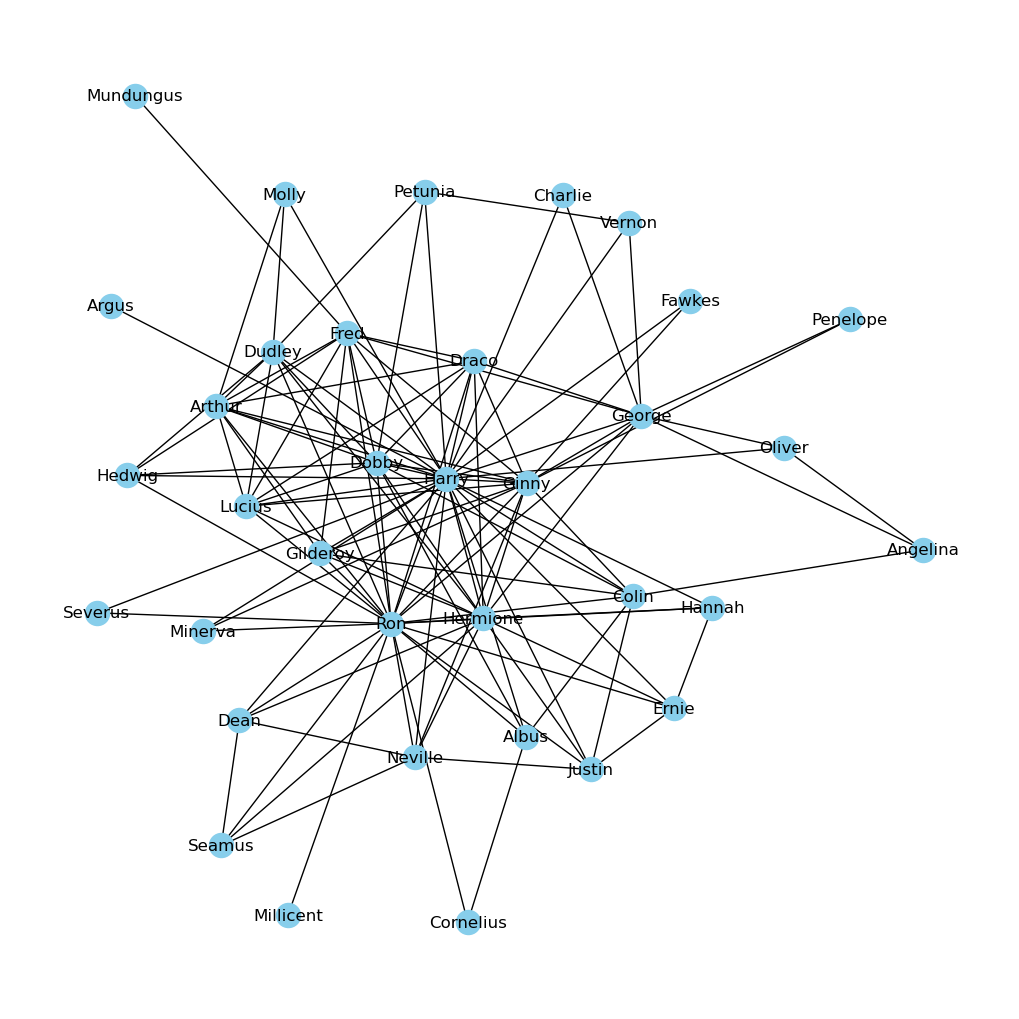

In [33]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [34]:
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("harry.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [35]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Dudley': 0.2647058823529412,
 'Petunia': 0.11764705882352941,
 'Harry': 0.8235294117647058,
 'Hedwig': 0.14705882352941177,
 'Vernon': 0.08823529411764705,
 'Hermione': 0.4411764705882353,
 'Ron': 0.7058823529411764,
 'Draco': 0.2647058823529412,
 'Dobby': 0.38235294117647056,
 'Albus': 0.14705882352941177,
 'George': 0.3235294117647059,
 'Fred': 0.3235294117647059,
 'Lucius': 0.2647058823529412,
 'Arthur': 0.29411764705882354,
 'Ginny': 0.4411764705882353,
 'Gilderoy': 0.20588235294117646,
 'Mundungus': 0.029411764705882353,
 'Molly': 0.08823529411764705,
 'Charlie': 0.058823529411764705,
 'Severus': 0.058823529411764705,
 'Minerva': 0.08823529411764705,
 'Dean': 0.14705882352941177,
 'Seamus': 0.11764705882352941,
 'Neville': 0.20588235294117646,
 'Justin': 0.1764705882352941,
 'Colin': 0.23529411764705882,
 'Angelina': 0.08823529411764705,
 'Oliver': 0.08823529411764705,
 'Argus': 0.029411764705882353,
 'Ernie': 0.14705882352941177,
 'Hannah': 0.11764705882352941,
 'Millicent': 0.

<AxesSubplot:>

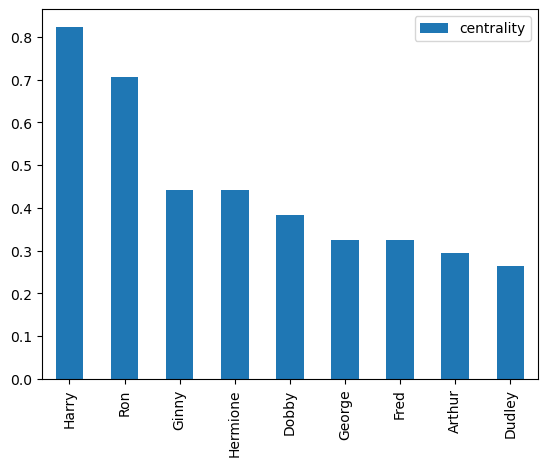

In [36]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

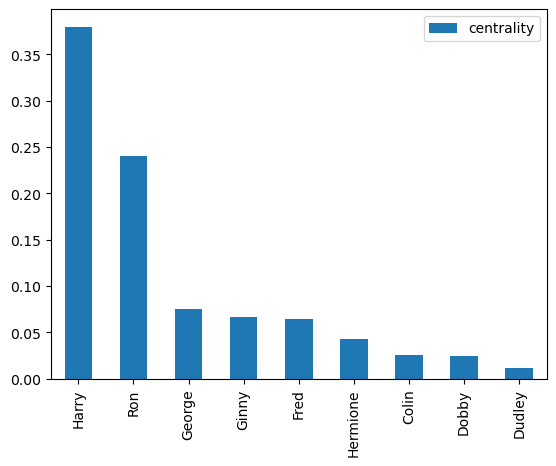

In [37]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<AxesSubplot:>

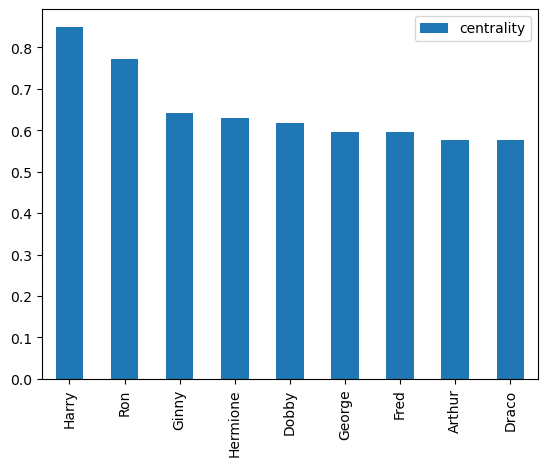

In [38]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [39]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

In [ ]:
#!pip install --upgrade python-louvain

In [ ]:
#!pip install python-louvain

In [41]:
communities = community.community_louvain.best_partition(G)
communities

{'Dudley': 1,
 'Petunia': 1,
 'Harry': 1,
 'Hedwig': 1,
 'Vernon': 1,
 'Hermione': 3,
 'Ron': 3,
 'Draco': 0,
 'Dobby': 0,
 'Albus': 2,
 'George': 2,
 'Fred': 0,
 'Lucius': 0,
 'Arthur': 0,
 'Ginny': 0,
 'Gilderoy': 0,
 'Mundungus': 0,
 'Molly': 1,
 'Charlie': 2,
 'Severus': 1,
 'Minerva': 1,
 'Dean': 3,
 'Seamus': 3,
 'Neville': 3,
 'Justin': 3,
 'Colin': 2,
 'Angelina': 2,
 'Oliver': 2,
 'Argus': 1,
 'Ernie': 3,
 'Hannah': 3,
 'Millicent': 3,
 'Cornelius': 2,
 'Fawkes': 1,
 'Penelope': 2}

In [42]:
nx.set_node_attributes(G, communities, 'group')

In [43]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("harry_communities.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
